<a href="https://colab.research.google.com/github/clearlakerabbit/ME793_Project/blob/main/ME793_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

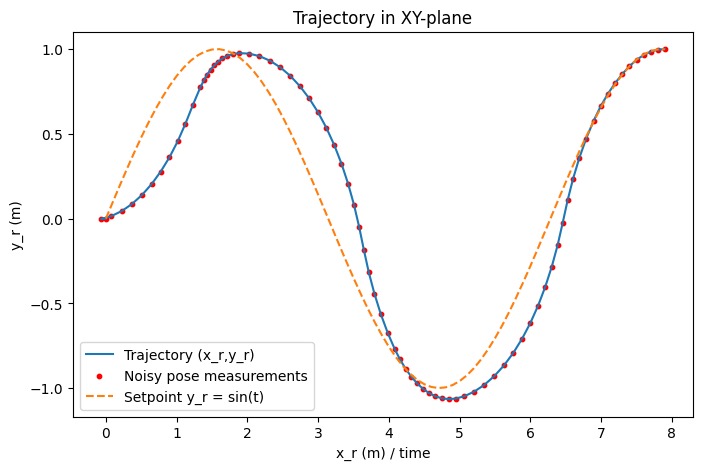

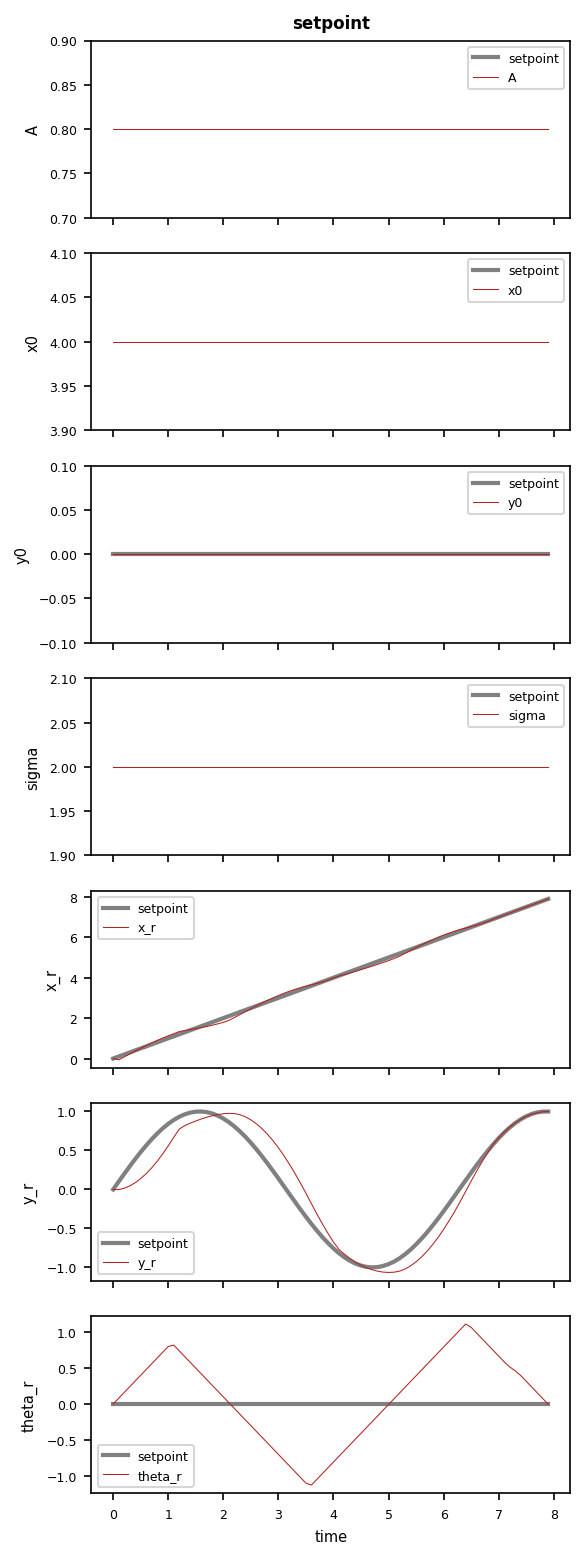

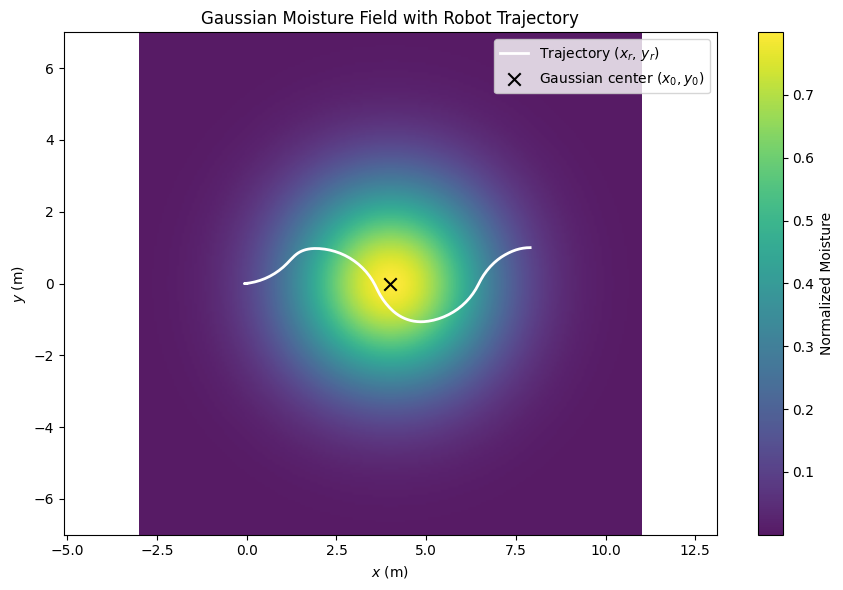

In [14]:
import pybounds
import numpy as np
import matplotlib.pyplot as plt

#parameters
params = dict(
    # Robot physical params
    m=20.0, kv=300.0, bv=20.0, Iz=1.0, kw=50.0, bw=2.0,
    # field parameters (real, for purposes of simulation)
    A_true=0.8, x0_true=4.0, y0_true=0.0, sigma_true=2.0,
    soil_type=1.0, # example scalar representing soil type
    force_alpha=500.0, # scaling for force model
    force_beta=200.0, # nonlinear term for force model
    # measurement noise (stddev)
    noise_pose_xy=0.2,
    noise_pose_theta=0.05,
    noise_moisture=0.02,
    noise_force=0.4
)

# dynamics
def f(x, u):
    v, w = u

    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x

    # static field parameters
    dA = 0.0
    dx0 = 0.0
    dy0 = 0.0
    dsigma = 0.0

    # simple unicycle kinematics for robot pose
    dx_r = v * np.cos(theta_r)
    dy_r = v * np.sin(theta_r)
    dtheta = w

    return [dA, dx0, dy0, dsigma, dx_r, dy_r, dtheta]

# measurement model
def g_m_from_state(x):
    # return moisture value m = Gaussian(A, x0, y0, sigma) evaluated at robot pose (x_r,y_r)
    A, x0, y0, sigma, x_r, y_r, theta_r = x
    sigma_eff = sigma if sigma > 1e-6 else 1e-6
    m_val = A * np.exp(-((x_r - x0)**2 + (y_r - y0)**2) / (2.0 * sigma_eff**2))
    return m_val

def force_model(m_local, soil_type=params['soil_type']):
    alpha = params['force_alpha']
    beta = params['force_beta']
    F = soil_type * (alpha * (1.0 - m_local) + beta * (1.0 - m_local)**2)
    return F

def h(x_vec, u_vec):
    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x_vec

    # pose measurements with additive Gaussian noise
    x_r_meas = x_r
    y_r_meas = y_r
    theta_meas = theta_r

    # environmental measurements
    m_local = g_m_from_state(x_vec)
    z_m = m_local

    # force measurement (nonlinear) + noise
    z_f = force_model(m_local)

    y_vec = [x_r_meas, y_r_meas, theta_meas, z_m, z_f]
    return y_vec

state_names = ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r']
input_names = ['v', 'w']
measurement_names = ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']
dt = 0.1
tsim = np.arange(0, 8.0, step=dt)

# create simulator
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names,
                               mpc_horizon=10)

# true initial states
x0 = [
    params['A_true'],
    params['x0_true'],
    params['y0_true'],
    params['sigma_true'],
    0.0, # x_r initial
    0.0, # y_r initial
    0.0 # theta_r initial
]

# setpoint/time-varying params
setpoint = {
    'x_r': tsim,
    'y_r': np.sin(tsim),
}
simulator.update_dict(setpoint, name='setpoint')

# objective function
cost_x = (simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2
cost_y = (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2
cost = cost_x + cost_y
simulator.mpc.set_objective(mterm=cost, lterm=cost)

simulator.mpc.set_rterm(v=1e-4, w=1e-4)

# input bounds
simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
simulator.mpc.bounds['upper', '_u', 'w'] = 0.8
simulator.mpc.bounds['lower', '_u', 'w'] = -0.8

# simulator
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, u=None, mpc=True, return_full_output=True)

# plot trajectory and measurements
plt.figure(figsize=(8, 5))
plt.plot(x_sim['x_r'], x_sim['y_r'], label='Trajectory (x_r,y_r)')
plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=10, label='Noisy pose measurements')
plt.plot(tsim, np.sin(tsim), '--', label='Setpoint y_r = sin(t)')
plt.xlabel('x_r (m) / time')
plt.ylabel('y_r (m)')
plt.title('Trajectory in XY-plane')
plt.legend()
simulator.plot('setpoint')
plt.tight_layout()
plt.show()

xr_traj = np.array(x_sim['x_r'])
yr_traj = np.array(x_sim['y_r'])

# padding for trajectory + Gaussian center
pad_x = 1.0
pad_y = 1.0

xmin = min(xr_traj.min(), params['x0_true'] - 3*params['sigma_true']) - pad_x
xmax = max(xr_traj.max(), params['x0_true'] + 3*params['sigma_true']) + pad_x
ymin = min(yr_traj.min(), params['y0_true'] - 3*params['sigma_true']) - pad_y
ymax = max(yr_traj.max(), params['y0_true'] + 3*params['sigma_true']) + pad_y

# grid for moisture field
nx, ny = 200, 200
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Gaussian moisture field (ground truth) with previously set params
A_true = params['A_true']
x0_true = params['x0_true']
y0_true = params['y0_true']
sigma_true = params['sigma_true']
Z = A_true * np.exp(-((X - x0_true)**2 + (Y - y0_true)**2) / (2 * sigma_true**2))

# start plotting
plt.figure(figsize=(9, 6))

# show moisture map first
im = plt.imshow(Z,
                extent=[xmin, xmax, ymin, ymax],
                origin='lower',
                cmap='viridis',
                alpha=0.9,
                aspect='auto')

# plot planned setpoint path
try:
    if 'x_r' in simulator.model.tvp and 'y_r' in simulator.model.tvp:
        plt.plot(simulator.model.tvp['x_r_set'], simulator.model.tvp['y_r_set'], 'k--', alpha=0.6, label='Setpoint path')
except Exception:
    pass

# robot trajectory and noisy pose measurements on top
plt.plot(xr_traj, yr_traj, color='white', linewidth=2, label='Trajectory ($x_r$, $y_r$)')
# plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=12, label='Noisy pose measurements', zorder=5)
plt.scatter([x0_true], [y0_true], marker='x', color='black', s=80, label='Gaussian center $(x_0, y_0)$', zorder=6)

plt.colorbar(im, label='Normalized Moisture')
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Gaussian Moisture Field with Robot Trajectory')
plt.legend(loc='upper right')
plt.axis('equal')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# w: sliding window size (samples)
w = 6

measurement_noise_stds = {
    'x_r': params['noise_pose_xy'],
    'y_r': params['noise_pose_xy'],
    'theta_r': params['noise_pose_theta'],
    'z_m': params['noise_moisture'],
    'z_f': params['noise_force'],
}

# convert to variances for Fisher computation
measurement_noise_vars = {k: v**2 for k, v in measurement_noise_stds.items()}

# construct the Sliding Empirical Observability Matrix (SEOM)
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# get list of observability matrices
O_sliding = SEOM.get_observability_matrix()
print(f"{len(O_sliding)} observability windows computed (w={w})")

# show columns (sensors x states x time-steps) available in the SEOM dataframe
print("Available measurement names:", SEOM.O_df_sliding[0].columns.tolist()[:20], "... (truncated)")

# compute Fisher information for the first sliding window
# FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)
# F, F_inv, R = FO.get_fisher_information()
# print("Fisher information matrix (window 0) shape:", F.shape)
# print("Fisher inverse (approx) shape:", F_inv.shape)

o_sensors = measurement_names.copy()  # ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']

# states from system
o_states = state_names.copy()  # ['A','x0','y0','sigma','x_r','y_r','theta_r']

# time steps inside each window to evaluate (indices relative to window), must be <= w
window_size = w if w is not None else len(t_sim)
o_time_steps = np.arange(0, min(window_size, 6), step=1)  # first few time indices in each window

# build R for selected sensors
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

# compute Sliding Fisher Observability across windows for chosen sensors/states/timesteps
SFO = pybounds.SlidingFisherObservability(
    SEOM.O_df_sliding,
    time=SEOM.t_sim,
    lam=1e-8,
    R=o_measurement_noise_vars,
    states=o_states,
    sensors=o_sensors,
    time_steps=o_time_steps,
    w=None
)


75 observability windows computed (w=6)
Available measurement names: ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r'] ... (truncated)


/tmp/ipython-input-451020859.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


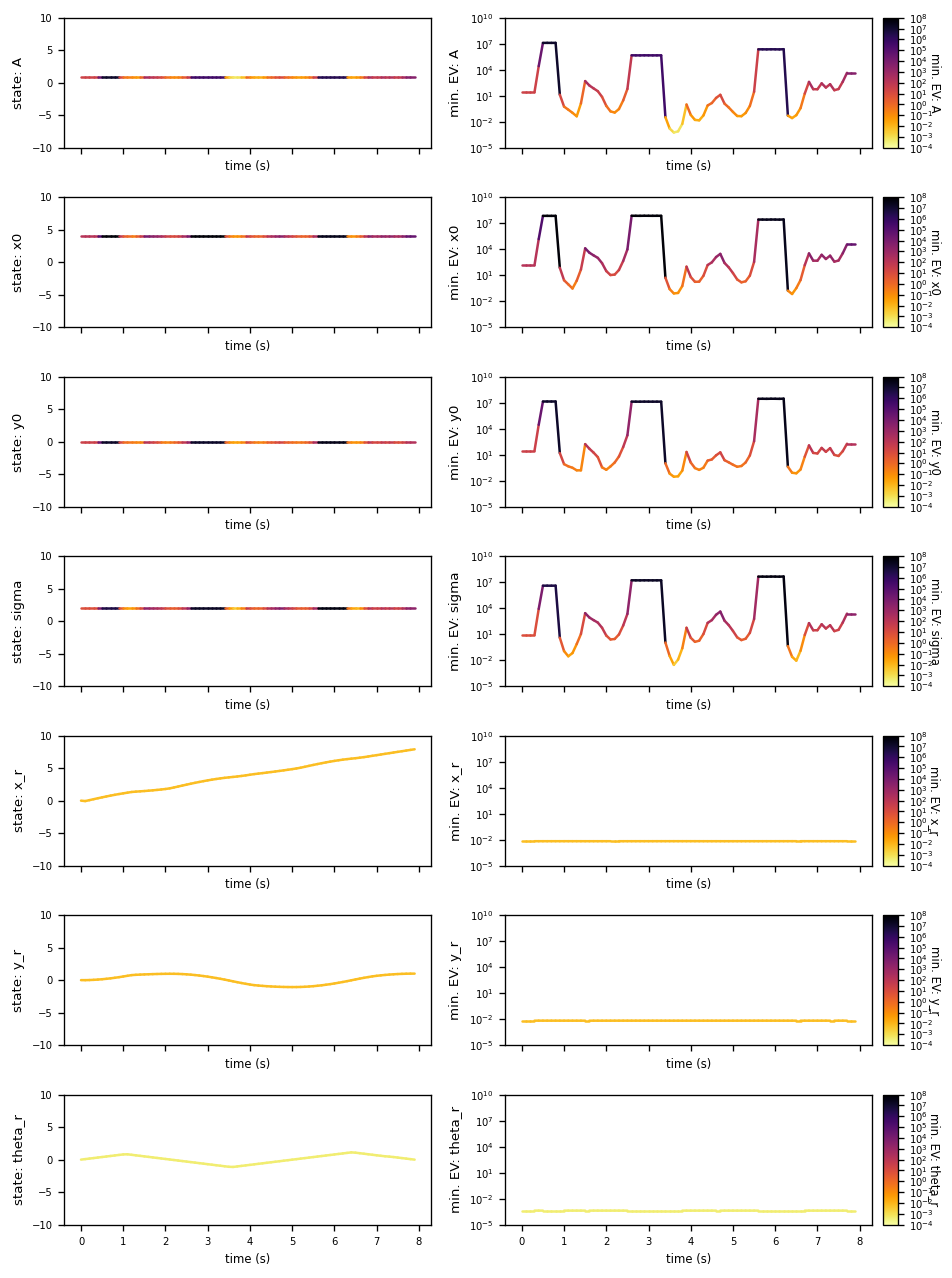

In [11]:
# pull out minimum error variance
EV_aligned = SFO.get_minimum_error_variance()

EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)
y_sim_df = pd.DataFrame(y_sim)

states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(8, n_state*1.6), dpi=120, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'
min_ev = np.nanmin(EV_no_nan.iloc[:, 2:].values)
max_ev = np.nanmax(EV_no_nan.iloc[:, 2:].values)

log_tick_low = int(np.floor(np.log10(min_ev)))
log_tick_high = int(np.ceil(np.log10(max_ev)))
cnorm = mpl.colors.LogNorm(vmin=10**log_tick_low, vmax=10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(SEOM.t_sim, x_sim_df[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(SEOM.t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 1], cmap=cmap, norm=cnorm)
    # colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(-10, 10)
    ax[n, 1].set_ylim(1e-5, 1e10)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=8)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=8)

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# median_evs = {s: np.nanmedian(EV_no_nan[s].values) for s in states}
# print("Median minimum error variance (per state):")
# for s, val in median_evs.items():
#     print(f"  {s}: {val:.3e}")